<a href="https://colab.research.google.com/github/hasan-rakibul/AI-cybersec/blob/main/lab_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated fraud detection for improved transaction security
In this experiment, we will use transaction data for online purchases collected from an ecommerce retailer. The dataset contains 39,221 transactions, each comprising 5 properties that can be used to describe the transaction, as well as a binary “label” indicating whether this transaction is an instance of fraud — “1” if fraudulent, and “0” if not.

**Reference book:** Chio, C., & Freeman, D. (2018). *Machine learning and security: Protecting systems with data and algorithms* (First edition). O’Reilly Media. (page 27)

**Reference programs:** https://github.com/oreilly-mlsec/book-resources/blob/master/chapter2/logistic-regression-fraud-detection.ipynb

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

## Dataset

Download the dataset and keep it on your Google drive folder (e.g., `Colab Notebooks/AICS/` folder)

Mount your Google Drive from "Files" menu.

In [2]:
# Read in the data from the CSV file
transaction_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AICS/payment_fraud.csv')

The above line reads in data from a CSV (Comma Separated Values) file and assigns it to a Pandas DataFrame object named "transaction_df".

- `pd`: This is a reference to the Pandas library, which is commonly used for data manipulation and analysis in Python.
- `read_csv()`: This is a function in Pandas that reads a CSV file and creates a DataFrame object from it. The path to the CSV file is passed as an argument to this function.
- `/content/drive/MyDrive/Colab Notebooks/AICS/payment_fraud.csv`: This is the path to the CSV file that is being read in. It is a string that specifies the file location on the system.
- `transaction_df`: This is the name given to the DataFrame object that is created from the CSV file.

## Exploratory data analysis

In [3]:
print(transaction_df.shape)

(39221, 6)


In [4]:
transaction_df.sample(10)

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,label
35403,2000,1,4.965339,creditcard,0.000000,0
12266,1162,1,4.965339,creditcard,85.881250,0
22451,1809,1,4.921349,paypal,0.000694,0
20601,251,1,4.886641,creditcard,0.000000,0
1614,129,1,4.057414,creditcard,0.000000,0
29811,165,1,4.962055,creditcard,0.000000,0
18304,637,2,4.836982,creditcard,166.045139,0
38097,259,1,4.505662,creditcard,0.000694,0
9891,20,1,4.524580,paypal,19.829861,0
13374,2000,1,4.836982,creditcard,211.435417,0


- `sample(10)`: This is a method in Pandas that returns a random sample of n rows from a DataFrame. In this case, the "sample()" method is called on the DataFrame object and 10 rows are selected randomly and printed to the console.

In [5]:
transaction_df.head(1)

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,label
0,29,1,4.745402,paypal,28.204861,0


- `head(1)`: This is a method in Pandas that returns the first n rows of a DataFrame object. In this case, we're asking for the first row only, so we pass the argument "1" to the "head()" method.

We see that this transaction was made through a user account that was created 29 days ago (accountAgeDays), and that the user purchased 1 item (numItems) at around 4:45 AM in the consumer’s local time (localTime). Payment was made through paypal (paymentMethod), and this method of payment was added about 28 days before the transaction (paymentMethodAgeDays). The label is 0, which indicates that this transaction is not fraudulent.

In [6]:
# checking missing/NaN values
print(transaction_df.isnull().any().any())

False


<Axes: xlabel='Label', ylabel='Frequency'>

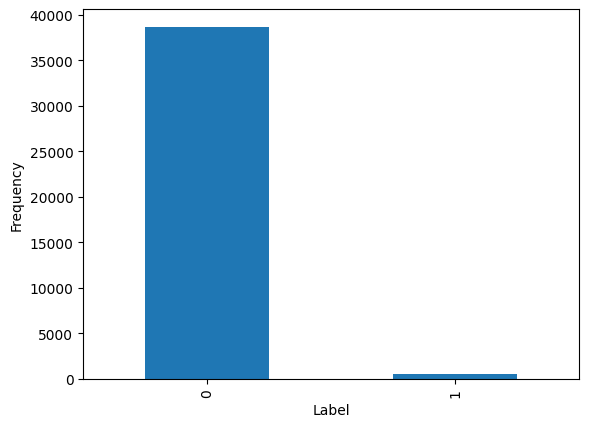

In [7]:
# Plotting - is the dataset balanced?
transaction_df['label'].value_counts().plot(
    kind='bar',
    xlabel='Label',
    ylabel='Frequency'
)

## Preprocessing

In [8]:
transaction_df.dtypes

accountAgeDays            int64
numItems                  int64
localTime               float64
paymentMethod            object
paymentMethodAgeDays    float64
label                     int64
dtype: object

In [9]:
transaction_df['paymentMethod'].unique()

array(['paypal', 'storecredit', 'creditcard'], dtype=object)

In [10]:
# First three samples before one-hot encoding
transaction_df.head(3)

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,label
0,29,1,4.745402,paypal,28.204861,0
1,725,1,4.742303,storecredit,0.000000,0
2,845,1,4.921318,creditcard,0.000000,0


In [11]:
# Convert categorical feature into dummy variables with one-hot encoding
transaction_df = pd.get_dummies(transaction_df, columns=['paymentMethod'])

# First three samples after one-hot encoding
transaction_df.head(3)

,accountAgeDays,numItems,localTime,paymentMethodAgeDays,label,paymentMethod_creditcard,paymentMethod_paypal,paymentMethod_storecredit
0,29,1,4.745402,28.204861,0,False,True,False
1,725,1,4.742303,0.000000,0,False,False,True
2,845,1,4.921318,0.000000,0,True,False,False


It converts a categorical feature in a Pandas DataFrame object named "transaction_df" into dummy variables using one-hot encoding. The resulting DataFrame is then assigned back to "transaction_df" and a random sample of 3 rows is printed to the console using the "sample()" method.

- `get_dummies()`: This is a function in Pandas that converts categorical variables into a series of binary variables (0 or 1) using one-hot encoding. The first argument to this function is the DataFrame object that contains the categorical feature, and the second argument is a list of columns to encode. In this case, the "paymentMethod" column is specified for encoding.
- `columns=['paymentMethod']`: This is a parameter of the "get_dummies()" function that specifies the column(s) to encode.
- `transaction_df`: This is the name of the DataFrame object that contains the categorical feature to be encoded using one-hot encoding. This object is passed as the first argument to the "get_dummies()" function.

In [12]:
transaction_df.dtypes

accountAgeDays                 int64
numItems                       int64
localTime                    float64
paymentMethodAgeDays         float64
label                          int64
paymentMethod_creditcard        bool
paymentMethod_paypal            bool
paymentMethod_storecredit       bool
dtype: object

In [13]:
# Split dataset up into train and test sets
X = transaction_df.drop('label', axis=1)
y = transaction_df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.33,
    random_state=17
)

It splits "transaction_df" into training and testing sets for machine learning purposes.

- `X = transaction_df.drop('label', axis=1)`: This line of code creates a new DataFrame object "X" that contains all the features from the "transaction_df" DataFrame except the 'label' column. This is done by using the "drop()" method on the "transaction_df" DataFrame and specifying the 'label' column to be dropped along the axis=1 (columns) dimension.
- `y = transaction_df['label']`: This line of code creates a new Pandas Series object "y" that contains the values of the 'label' column from the "transaction_df" DataFrame.
- `train_test_split()`: This is a function in the scikit-learn library that splits a dataset into training and testing subsets. The first argument to this function is the feature set "X", the second argument is the target variable "y", and the remaining arguments specify the parameters for the split. In this case, we specify that 33% of the data should be used for testing and 67% for training, and we set the random_state parameter to 17 to ensure that the split is reproducible.
- `X_train, X_test, y_train, y_test`: This line of code assigns the output of the "train_test_split()" function to four variables: "X_train", "X_test", "y_train", and "y_test". The first two variables contain the training and testing feature sets, respectively, while the last two variables contain the corresponding target variable subsets.

## Classification

In [14]:
# Initialize and train classifier model
classifier = LogisticRegression().fit(X_train, y_train)

# Make predictions on test set
y_pred = classifier.predict(X_test)

It initialises and trains a logistic regression classifier model using the training subset of a dataset, and then uses the trained model to make predictions on the testing subset.

- `classifier = LogisticRegression().fit(X_train, y_train)`: This line of code creates a logistic regression classifier object using the scikit-learn library and fits it to the training feature set and target variable. The LogisticRegression() function initializes a new logistic regression classifier object, and the fit() method trains the classifier using the training feature set X_train and target variable y_train.
- `y_pred = classifier.predict(X_test)`: This line of code uses the trained logistic regression classifier model to make predictions on the testing feature set X_test, and assigns the predicted values to a new variable y_pred. The predict() method of the classifier takes as input the feature set X_test, and returns an array of predicted values based on the model's learned parameters.

Supplementary reading: [Logistic Regression for Machine Learning &ndash; Machine Learning Mastery](https://machinelearningmastery.com/logistic-regression-for-machine-learning/)

In [15]:
# Compare test set predictions with ground truth labels
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

1.0
[[12753     0]
 [    0   190]]
1.0


It evaluates the performance of the logistic regression model for fraud detection by comparing its predictions with the ground truth labels of a testing subset.

- `accuracy_score(y_pred, y_test)`: This line of code computes the accuracy of the model's predictions on the testing feature set X_test by comparing them to the ground truth labels in the testing target variable y_test. The accuracy_score() function from the scikit-learn library takes as input two arrays, y_pred (the predicted values) and y_test (the actual values), and returns a floating-point value between 0 and 1 that represents the percentage of correct predictions made by the model on the testing set.
- `confusion_matrix(y_test, y_pred)`: This line of code computes a confusion matrix for the model's predictions on the testing feature set X_test. A confusion matrix is a table that summarizes the performance of a classification model by comparing its predicted labels with the actual labels. The confusion_matrix() function from the scikit-learn library takes as input two arrays, y_test (the actual values) and y_pred (the predicted values), and returns a 2x2 matrix that shows the number of true positives, true negatives, false positives, and false negatives in the predictions.

## Practice task
Experiment with different machine learning models: In the lab, we used a logistic regression classifier to detect payment fraud. For homework, you could experiment with other classification models like decision trees, random forests, support vector machines or neural networks. Compare their performance on the testing set using metrics like accuracy, precision, recall and F1 score.